# Paczki

In [1]:
import pandas as pd
import lightgbm as lgbm
import mlflow
from xgboost import XGBClassifier

from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import os
import math

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, f1_score, RocCurveDisplay, roc_auc_score
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, GRU, Dense, Masking, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Przeliczenia modeli

## Wszystkie Zmienne

In [2]:
test_all_variables = pd.read_parquet("data/states_another_mod_test.parquet")
test_all_variables.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620392 entries, 0 to 620391
Columns: 108 entries, filename to bombsite_not_planted
dtypes: float64(17), int32(7), int64(68), object(6), uint8(10)
memory usage: 457.9+ MB


In [3]:
def select_feat(prep_df):
    columns = [
        'seconds', 'ctAlivePlayers', 'ctEqVal', 'tAlivePlayers', 'tEqVal',
       'ct_armor', 't_armor', 'ct_hp', 't_hp', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade', 'ct_fireGrenades',
       't_fireGrenades', 'ct_isBlinded', 't_isBlinded', 'ct_hasDefuse',
       't_hasBomb', 'ct_isDefusing', 't_isPlanting', 'ct_spottedPlayers',
       't_spottedPlayers', 'ct_grouppedPlayers',
       'ct_meanDist', 'ct_minDist', 't_meanDist','t_minDist',
       't_grouppedPlayers', 'ct_conquerMap', 't_conquerMap', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_SniperRifle',
       'ct_activeWeapon_AssaultRifle', 'ct_activeWeapon_Others',
       't_activeWeapon_Pistol', 't_activeWeapon_EnhancedPistols',
       't_activeWeapon_Deagle', 't_activeWeapon_SMG',
       't_activeWeapon_WeakAssaultRifle', 't_activeWeapon_LunetRifle',
       't_activeWeapon_SniperRifle', 't_activeWeapon_AssaultRifle',
       't_activeWeapon_Others', 'ct_mainWeapon_Pistol',
       'ct_mainWeapon_EnhancedPistols', 'ct_mainWeapon_Deagle',
       'ct_mainWeapon_SMG', 'ct_mainWeapon_WeakAssaultRifle',
       'ct_mainWeapon_LunetRifle', 'ct_mainWeapon_SniperRifle',
       'ct_mainWeapon_AssaultRifle', 't_mainWeapon_Pistol', 't_mainWeapon_EnhancedPistols',
       't_mainWeapon_Deagle', 't_mainWeapon_SMG',
       't_mainWeapon_WeakAssaultRifle', 't_mainWeapon_LunetRifle',
       't_mainWeapon_SniperRifle', 't_mainWeapon_AssaultRifle', 
       'ct_secondaryWeapon_Pistol','ct_secondaryWeapon_EnhancedPistols', 'ct_secondaryWeapon_Deagle',
       't_secondaryWeapon_Pistol', 't_secondaryWeapon_EnhancedPistols',
       't_secondaryWeapon_Deagle', 'ctMinDistToA',
       'ctMinDistToB', 'tMinDistToA', 'tMinDistToB', 'ctMeanDistToA',
       'ctMeanDistToB', 'tMeanDistToA', 'tMeanDistToB', 'ctMeanKills',
       'tMeanKills', 'tScore', 'ctScore', 'de_ancient', 
       'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke', 'de_overpass',
       'de_vertigo','bombsite_A', 'bombsite_B', 'bombsite_not_planted'
    ]
    return prep_df[columns]

test_frame_all_variables = select_feat(test_all_variables)
test_frame_all_variables.info()
target = test_all_variables['winningSideCT']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620392 entries, 0 to 620391
Data columns (total 99 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   seconds                             620392 non-null  float64
 1   ctAlivePlayers                      620392 non-null  int64  
 2   ctEqVal                             620392 non-null  int64  
 3   tAlivePlayers                       620392 non-null  int64  
 4   tEqVal                              620392 non-null  int64  
 5   ct_armor                            620392 non-null  int64  
 6   t_armor                             620392 non-null  int64  
 7   ct_hp                               620392 non-null  int64  
 8   t_hp                                620392 non-null  int64  
 9   ct_hasHelmet                        620392 non-null  int64  
 10  t_hasHelmet                         620392 non-null  int64  
 11  ct_DecoyGrenade           

In [4]:
def load_pickle(path):
    with open(path, "rb") as handle:
        model = pickle.load(handle)
    return model

In [5]:
def generate_indices(data, lookback):
    grouped = data.groupby(['matchID', 'roundNum'])
    dict_gr = grouped.indices
    for key, val in dict_gr.items():
        dict_gr[key] = np.min(val),  np.max(val)
    
    indices = np.zeros((len(data.index), lookback), dtype=np.int32)
    for key in dict_gr:
        minimum, maximum = dict_gr[key]
        for i in range(minimum, maximum + 1):
            if i - minimum < lookback:
                indices[i] = np.hstack((np.repeat(-1, lookback - (i + 1 - minimum)), np.arange(minimum, i + 1, dtype=np.int32)))
            else:
                indices[i] = np.arange(i + 1 - lookback, i + 1, dtype=np.int32)
    return indices

In [6]:
class CSGOsequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, indices, shuffle):
        self.x, self.y = x_set, y_set
        self.indices = indices
        self.batch_size = batch_size
        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return math.ceil(self.indices.shape[0] / self.batch_size)
                         
    def __getitem__(self, idx):
        batch_x = [np.array([np.zeros(self.x.shape[-1]) if val < 0 else self.x[val] 
                   for val in index])
                       for index in self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]]
        batch_y = self.y[self.indices[idx * self.batch_size : (idx + 1) * self.batch_size, -1]]
        return np.array(batch_x), np.array(batch_y)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [7]:
all_variables = {
    "RNN_70": {
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/ba8603f5c50244e58a0c5e9616083fad/artifacts/model/model.tf",
        "sequence": 70
    },
    "MLP": {
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/a998c04fa1224117b50cedd848334960/artifacts/model/model.tf",
    },
    "RF": {
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/4de07e59fcc348f58e540d5304ad3b74/artifacts/model/model.pkl",
    },
    "XGB":{
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/478497dd91364c3d8266d96eaec573cd/artifacts/model/model.pkl"
    },
    "LR": {
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/1517312130cf46edad5cf68cc195cc02/artifacts/model/model.pkl"
    },
    "LGBM": {
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/6596a5985e6e40dfa556d5aa8ad73a18/artifacts/model/model.pkl"
    },
    "RNN_20":{
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/d0cd83b3a9af4c4b8ae1d9a2f390de2a/artifacts/model/model.tf",
        "sequence": 20
    }
}

In [8]:
scaler = load_pickle("scalers/all_var.pickle")
norm_test_frame_av = scaler.transform(test_frame_all_variables)
results_all = {}
for model in all_variables:
    print(model)
    if all_variables[model]["path"].endswith("tf"):
        path = all_variables[model]["path"]
        if "sequence" in all_variables[model]:
            sequence = all_variables[model]["sequence"]
            test_indices = generate_indices(test_all_variables, sequence)
            test_seq = CSGOsequence(x_set=norm_test_frame_av, y_set=target.values, batch_size=2048,
                                    indices=test_indices, shuffle=False)
            model_loaded = load_model(path)
            y_predict = model_loaded.predict(test_seq).flatten()
        else:
            model_loaded = load_model(path)
            y_predict = model_loaded.predict(norm_test_frame_av).flatten()
        results_all[model] = y_predict
        
    elif all_variables[model]["path"].endswith("pkl"):
        path = all_variables[model]["path"]
        model_loaded = load_pickle(path)
        y_predict = model_loaded.predict_proba(test_frame_all_variables)[:, 1]
        results_all[model] = y_predict

results_all

RNN_70
MLP
RF
XGB
LR
LGBM
RNN_20


{'RNN_70': array([0.50649697, 0.49469674, 0.48514336, ..., 0.11428686, 0.11445986,
        0.11456659], dtype=float32),
 'MLP': array([0.49028742, 0.49050277, 0.4858058 , ..., 0.02403999, 0.02406023,
        0.02408046], dtype=float32),
 'RF': array([0.535     , 0.535     , 0.53166667, ..., 0.00333333, 0.00333333,
        0.00333333]),
 'XGB': array([0.59124064, 0.59124064, 0.59124064, ..., 0.02619207, 0.02619207,
        0.02619207], dtype=float32),
 'LR': array([0.58146837, 0.5816051 , 0.59601813, ..., 0.0180904 , 0.01810039,
        0.01811037]),
 'LGBM': array([0.55718701, 0.55718701, 0.55718701, ..., 0.02980411, 0.02980411,
        0.02898585]),
 'RNN_20': array([0.53258634, 0.5347025 , 0.5346999 , ..., 0.09059048, 0.09078348,
        0.09089786], dtype=float32)}

## Zmienne z Boruty

In [9]:
def select_bor_feat(prep_df):
    columns = ['t_activeWeapon_LunetRifle', 't_hasHelmet', 'de_dust2', 'ct_activeWeapon_SMG', 't_grouppedPlayers', 'ct_secondaryWeapon_Deagle', 
               'ct_mainWeapon_EnhancedPistols', 'ct_hasHelmet', 't_meanDist', 'ct_SmokeGrenade', 'ctMeanKills', 't_mainWeapon_AssaultRifle', 
               't_conquerMap', 'ct_HEGrenade', 
               'ctAlivePlayers', 'ctMinDistToB', 't_hp', 't_hasBomb', 'ct_spottedPlayers', 't_activeWeapon_WeakAssaultRifle', 'ct_mainWeapon_Pistol', 
               'ct_activeWeapon_AssaultRifle', 'tMinDistToB', 'de_mirage', 't_isPlanting', 'ctMeanDistToB', 'ct_secondaryWeapon_EnhancedPistols', 
               't_secondaryWeapon_Deagle', 
               'tMinDistToA', 't_mainWeapon_LunetRifle', 'ct_mainWeapon_Deagle', 'bombsite_B', 't_mainWeapon_Pistol', 't_mainWeapon_WeakAssaultRifle', 
               'bombsite_A', 'ctMinDistToA', 'bombsite_not_planted', 'ct_meanDist', 'tScore', 'ct_activeWeapon_WeakAssaultRifle', 'ct_conquerMap', 
               'ct_fireGrenades', 't_Flashbang', 't_activeWeapon_SniperRifle', 't_activeWeapon_Deagle', 'tMeanKills', 't_mainWeapon_SniperRifle', 
               'ct_armor', 'ct_hp', 'ct_Flashbang', 'ct_mainWeapon_WeakAssaultRifle', 'de_overpass', 'de_ancient', 'ctMeanDistToA', 'de_inferno', 
               't_mainWeapon_SMG', 'tMeanDistToA', 'de_vertigo', 'tAlivePlayers', 't_activeWeapon_EnhancedPistols', 't_HEGrenade', 'ct_mainWeapon_LunetRifle',
               'ct_isDefusing', 't_armor', 'ct_activeWeapon_Deagle', 'ct_minDist', 't_fireGrenades', 'ctScore', 'tEqVal', 
               'ct_DecoyGrenade', 'ctEqVal', 'seconds', 'ct_hasDefuse', 'ct_mainWeapon_SniperRifle', 'ct_mainWeapon_SMG', 't_SmokeGrenade',
               't_mainWeapon_Deagle', 'ct_secondaryWeapon_Pistol', 'tMeanDistToB', 't_DecoyGrenade', 'de_nuke', 't_secondaryWeapon_EnhancedPistols', 
               'ct_mainWeapon_AssaultRifle', 't_minDist', 't_secondaryWeapon_Pistol']
    return prep_df[columns]

test_frame_bor_variables = select_bor_feat(test_all_variables)
target = test_all_variables['winningSideCT']
test_frame_bor_variables.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620392 entries, 0 to 620391
Data columns (total 85 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   t_activeWeapon_LunetRifle           620392 non-null  int64  
 1   t_hasHelmet                         620392 non-null  int64  
 2   de_dust2                            620392 non-null  uint8  
 3   ct_activeWeapon_SMG                 620392 non-null  int64  
 4   t_grouppedPlayers                   620392 non-null  int64  
 5   ct_secondaryWeapon_Deagle           620392 non-null  int64  
 6   ct_mainWeapon_EnhancedPistols       620392 non-null  int32  
 7   ct_hasHelmet                        620392 non-null  int64  
 8   t_meanDist                          620392 non-null  float64
 9   ct_SmokeGrenade                     620392 non-null  int64  
 10  ctMeanKills                         620392 non-null  float64
 11  t_mainWeapon_AssaultRifle 

In [10]:
bor_variables = {
    "RNN_70": {
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/5f99546c4a844180b1528e0c0c7d23c9/artifacts/model/model.tf",
        "sequence": 70
    },
    "MLP": {
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/23ea639bfe05436691cc757f18b59630/artifacts/model/model.tf",
    },
    "XGB":{
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/2ef6f528b07646b0857cbe88f7115ed6/artifacts/model/model.pkl"
    },
    "LR": {
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/2b41b3146e04445bb0c7d57dc0479b7a/artifacts/model/model.pkl"
    },
    "LGBM": {
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/924ea3ea21af4378ae02b159d0bee5d6/artifacts/model/model.pkl"
    },
    "RNN_20":{
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/68387107e4844ee5a13a99bc576b45e7/artifacts/model/model.tf",
        "sequence": 20
    }
}

In [11]:
scaler = load_pickle("scalers/select_var.pickle")
norm_test_frame_av = scaler.transform(test_frame_bor_variables)
results_select = {}
for model in bor_variables:
    print(model)
    if bor_variables[model]["path"].endswith("tf"):
        path = bor_variables[model]["path"]
        if "sequence" in bor_variables[model]:
            sequence = bor_variables[model]["sequence"]
            test_indices = generate_indices(test_all_variables, sequence)
            test_seq = CSGOsequence(x_set=norm_test_frame_av, y_set=target.values, batch_size=2048,
                                    indices=test_indices, shuffle=False)
            model_loaded = load_model(path)
            y_predict = model_loaded.predict(test_seq).flatten()
        else:
            model_loaded = load_model(path)
            y_predict = model_loaded.predict(norm_test_frame_av).flatten()
        results_select[model] = y_predict
    elif bor_variables[model]["path"].endswith("pkl"):
        path = bor_variables[model]["path"]
        model_loaded = load_pickle(path)
        y_predict = model_loaded.predict_proba(test_frame_bor_variables)[:, 1]
        results_select[model] = y_predict

results_select

RNN_70
MLP
XGB
LR
LGBM
RNN_20


{'RNN_70': array([0.56514645, 0.5855099 , 0.59712815, ..., 0.08080858, 0.08094715,
        0.08103143], dtype=float32),
 'MLP': array([0.49806926, 0.4982657 , 0.49846205, ..., 0.02399205, 0.02401045,
        0.02402887], dtype=float32),
 'XGB': array([0.59000885, 0.59000885, 0.59000885, ..., 0.02403298, 0.02403298,
        0.02403298], dtype=float32),
 'LR': array([0.60671365, 0.60684996, 0.60698625, ..., 0.01748223, 0.01749204,
        0.01750186]),
 'LGBM': array([0.53171041, 0.53171041, 0.53171041, ..., 0.03352059, 0.03352059,
        0.03352059]),
 'RNN_20': array([0.51314473, 0.5079935 , 0.50521487, ..., 0.09098517, 0.09111323,
        0.09119309], dtype=float32)}

## Początkowe Zmienne

In [12]:
test_begin = pd.read_parquet("data/states_prepared_test.parquet")
test_begin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620392 entries, 0 to 620391
Columns: 108 entries, filename to bombsite_not_planted
dtypes: float64(9), int32(7), int64(76), object(6), uint8(10)
memory usage: 453.2+ MB


In [13]:
def select_beg_feat(prep_df):
    columns = [
        'seconds', 'ctAlivePlayers', 'ctEqVal', 'tAlivePlayers', 'tEqVal',
       'ct_armor', 't_armor', 'ct_hp', 't_hp', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade', 'ct_fireGrenades',
       't_fireGrenades', 'ct_isBlinded', 't_isBlinded', 'ct_hasDefuse',
       't_hasBomb', 'ct_isDefusing', 't_isPlanting', 'ct_spottedPlayers',
       't_spottedPlayers', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_SniperRifle',
       'ct_activeWeapon_AssaultRifle', 'ct_activeWeapon_Others',
       't_activeWeapon_Pistol', 't_activeWeapon_EnhancedPistols',
       't_activeWeapon_Deagle', 't_activeWeapon_SMG',
       't_activeWeapon_WeakAssaultRifle', 't_activeWeapon_LunetRifle',
       't_activeWeapon_SniperRifle', 't_activeWeapon_AssaultRifle',
       't_activeWeapon_Others', 'ct_mainWeapon_Pistol',
       'ct_mainWeapon_EnhancedPistols', 'ct_mainWeapon_Deagle',
       'ct_mainWeapon_SMG', 'ct_mainWeapon_WeakAssaultRifle',
       'ct_mainWeapon_LunetRifle', 'ct_mainWeapon_SniperRifle',
       'ct_mainWeapon_AssaultRifle', 'ct_mainWeapon_Others',
       't_mainWeapon_Pistol', 't_mainWeapon_EnhancedPistols',
       't_mainWeapon_Deagle', 't_mainWeapon_SMG',
       't_mainWeapon_WeakAssaultRifle', 't_mainWeapon_LunetRifle',
       't_mainWeapon_SniperRifle', 't_mainWeapon_AssaultRifle',
       't_mainWeapon_Others', 'ct_secondaryWeapon_Pistol',
       'ct_secondaryWeapon_EnhancedPistols', 'ct_secondaryWeapon_Deagle',
       't_secondaryWeapon_Pistol', 't_secondaryWeapon_EnhancedPistols',
       't_secondaryWeapon_Deagle', 'ctMinDistToA',
       'ctMinDistToB', 'tMinDistToA', 'tMinDistToB', 'ctMeanDistToA',
       'ctMeanDistToB', 'tMeanDistToA', 'tMeanDistToB', 'de_ancient',
       'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke', 'de_overpass',
       'de_vertigo','bombsite_A', 'bombsite_B', 'bombsite_not_planted'
    ]
    return prep_df[columns]

test_frame_begin_variables = select_beg_feat(test_begin)
target = test_begin['winningSideCT']
test_frame_begin_variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620392 entries, 0 to 620391
Data columns (total 89 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   seconds                             620392 non-null  float64
 1   ctAlivePlayers                      620392 non-null  int64  
 2   ctEqVal                             620392 non-null  int64  
 3   tAlivePlayers                       620392 non-null  int64  
 4   tEqVal                              620392 non-null  int64  
 5   ct_armor                            620392 non-null  int64  
 6   t_armor                             620392 non-null  int64  
 7   ct_hp                               620392 non-null  int64  
 8   t_hp                                620392 non-null  int64  
 9   ct_hasHelmet                        620392 non-null  int64  
 10  t_hasHelmet                         620392 non-null  int64  
 11  ct_DecoyGrenade           

In [14]:
begin_variables = {
    "RNN_100": {
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/35a8280e88ce48c78927dab6d5a3db6f/artifacts/model/model.tf",
        "sequence": 100
    },
    "RNN_70": {
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/146ee380abd94b26bbd8a374bfe24d9a/artifacts/model/model.tf",
        "sequence": 70
    },
    "RNN_20":{
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/9f5fe250122d44aab6c46acab5b13460/artifacts/model/model.tf",
        "sequence": 20
    },
    "MLP": {
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/46ca722706e24f6b83814556fdeee3be/artifacts/model/model.tf",
    },
    "XGB":{
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/9f6bb1a1e0d74e6ca465b67d6ac76827/artifacts/model/model.pkl"
    },
    "RF":{
        "path": "E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/9aa80cbd9d274e9c83d70cdfd2ee60bc/artifacts/model/model.pkl"
    },
    "LR": {
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/5bab4777f7164fc690c3626af1849388/artifacts/model/model.pkl"
    },
    "LGBM": {
        "path": r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/14cd7a9589ce483db318cd4c3aaa6c5a/artifacts/model/model.pkl"
    }
}

In [15]:
scaler = load_pickle("scalers/select_beg.pickle")
norm_test_frame_av = scaler.transform(test_frame_begin_variables)
results_beg = {}
for model in begin_variables:
    print(model)
    if begin_variables[model]["path"].endswith("tf"):
        path = begin_variables[model]["path"]
        if "sequence" in begin_variables[model]:
            sequence = begin_variables[model]["sequence"]
            test_indices = generate_indices(test_all_variables, sequence)
            test_seq = CSGOsequence(x_set=norm_test_frame_av, y_set=target.values, batch_size=2048,
                                    indices=test_indices, shuffle=False)
            model_loaded = load_model(path)
            y_predict = model_loaded.predict(test_seq).flatten()
        else:
            model_loaded = load_model(path)
            y_predict = model_loaded.predict(norm_test_frame_av).flatten()
        results_beg[model] = y_predict
    elif begin_variables[model]["path"].endswith("pkl"):
        path = begin_variables[model]["path"]
        model_loaded = load_pickle(path)
        y_predict = model_loaded.predict_proba(test_frame_begin_variables)[:, 1]
        results_beg[model] = y_predict

results_beg

RNN_100
RNN_70
RNN_20
MLP
XGB
RF
LR
LGBM


{'RNN_100': array([0.50774264, 0.49918082, 0.49520978, ..., 0.09841993, 0.09828555,
        0.09821113], dtype=float32),
 'RNN_70': array([0.4998913 , 0.48561147, 0.48752356, ..., 0.09969104, 0.09972554,
        0.09974971], dtype=float32),
 'RNN_20': array([0.51044744, 0.50053537, 0.5013543 , ..., 0.10255539, 0.10268941,
        0.10276605], dtype=float32),
 'MLP': array([0.45940483, 0.4594576 , 0.4706262 , ..., 0.03357081, 0.0335777 ,
        0.03358461], dtype=float32),
 'XGB': array([0.52129936, 0.52129936, 0.52129936, ..., 0.02567062, 0.02567062,
        0.02567062], dtype=float32),
 'RF': array([0.44666667, 0.44666667, 0.45      , ..., 0.00166667, 0.00166667,
        0.00166667]),
 'LR': array([0.59217169, 0.59219077, 0.60837422, ..., 0.03102963, 0.03103201,
        0.03103438]),
 'LGBM': array([0.50897676, 0.50897676, 0.50897676, ..., 0.03497649, 0.03497649,
        0.03407121])}

# Tabela

In [16]:
past = test_all_variables['filename'].str.startswith("IEM-Katowice")
future = test_all_variables['filename'].str.startswith("BLAST-Premier-Spring-Final-2022")
past.value_counts(), future.value_counts()

(True     321041
 False    299351
 Name: filename, dtype: int64,
 False    321041
 True     299351
 Name: filename, dtype: int64)

In [17]:
index = []
results = []
y_true = test_all_variables['winningSideCT']
for key in results_all:
    index.append(f"{key} (All Variables)")
    y_pred = results_all[key]
    results.append({
        "LogLoss (all)": log_loss(y_true, y_pred),
        "LogLoss (future)": log_loss(y_true[future], y_pred[future]),
        "LogLoss (past)": log_loss(y_true[past], y_pred[past]),
        "AUC-ROC (all)": roc_auc_score(y_true, y_pred),
        "AUC-ROC (future)": roc_auc_score(y_true[future], y_pred[future]),
        "AUC-ROC (past)": roc_auc_score(y_true[past], y_pred[past])
    })
    
    
for key in results_select:
    index.append(f"{key} (Boruta Variables)")
    y_pred = results_select[key]
    results.append({
        "LogLoss (all)": log_loss(y_true, y_pred),
        "LogLoss (future)": log_loss(y_true[future], y_pred[future]),
        "LogLoss (past)": log_loss(y_true[past], y_pred[past]),
        "AUC-ROC (all)": roc_auc_score(y_true, y_pred),
        "AUC-ROC (future)": roc_auc_score(y_true[future], y_pred[future]),
        "AUC-ROC (past)": roc_auc_score(y_true[past], y_pred[past])
    })

y_true = test_begin['winningSideCT']
for key in results_beg:
    index.append(f"{key} (Start Variables)")
    y_pred = results_beg[key]
    results.append({
        "LogLoss (all)": log_loss(y_true, y_pred),
        "LogLoss (future)": log_loss(y_true[future], y_pred[future]),
        "LogLoss (past)": log_loss(y_true[past], y_pred[past]),
        "AUC-ROC (all)": roc_auc_score(y_true, y_pred),
        "AUC-ROC (future)": roc_auc_score(y_true[future], y_pred[future]),
        "AUC-ROC (past)": roc_auc_score(y_true[past], y_pred[past])
    })

results_df = pd.DataFrame.from_records(index=index, data=results)
results_df

,LogLoss (all),LogLoss (future),LogLoss (past),AUC-ROC (all),AUC-ROC (future),AUC-ROC (past)
RNN_70 (All Variables),0.491340,0.491881,0.490835,0.844779,0.847245,0.842021
MLP (All Variables),0.468925,0.470186,0.467750,0.847980,0.850533,0.845037
RF (All Variables),0.732763,0.763793,0.703829,0.838517,0.844016,0.831984
XGB (All Variables),0.464547,0.463474,0.465547,0.851671,0.856141,0.846788
LR (All Variables),0.468281,0.470227,0.466466,0.847555,0.848883,0.846114
LGBM (All Variables),0.464280,0.463007,0.465467,0.851093,0.855065,0.846622
RNN_20 (All Variables),0.487892,0.487622,0.488143,0.845623,0.849082,0.841963
RNN_70 (Boruta Variables),0.484915,0.484183,0.485597,0.847347,0.850901,0.843486
MLP (Boruta Variables),0.467986,0.467876,0.468088,0.849086,0.852204,0.845630
XGB (Boruta Variables),0.465687,0.464758,0.466552,0.850167,0.853984,0.845788


In [18]:
results_df[["LogLoss (all)", "LogLoss (future)", "LogLoss (past)"]].sort_values(by="LogLoss (all)")

,LogLoss (all),LogLoss (future),LogLoss (past)
LGBM (Start Variables),0.458841,0.456802,0.460743
XGB (Start Variables),0.460579,0.459372,0.461704
LGBM (All Variables),0.464280,0.463007,0.465467
XGB (All Variables),0.464547,0.463474,0.465547
XGB (Boruta Variables),0.465687,0.464758,0.466552
LGBM (Boruta Variables),0.466299,0.466554,0.466061
MLP (Start Variables),0.466668,0.467592,0.465805
MLP (Boruta Variables),0.467986,0.467876,0.468088
LR (Start Variables),0.468145,0.469602,0.466786
LR (Boruta Variables),0.468181,0.469817,0.466655


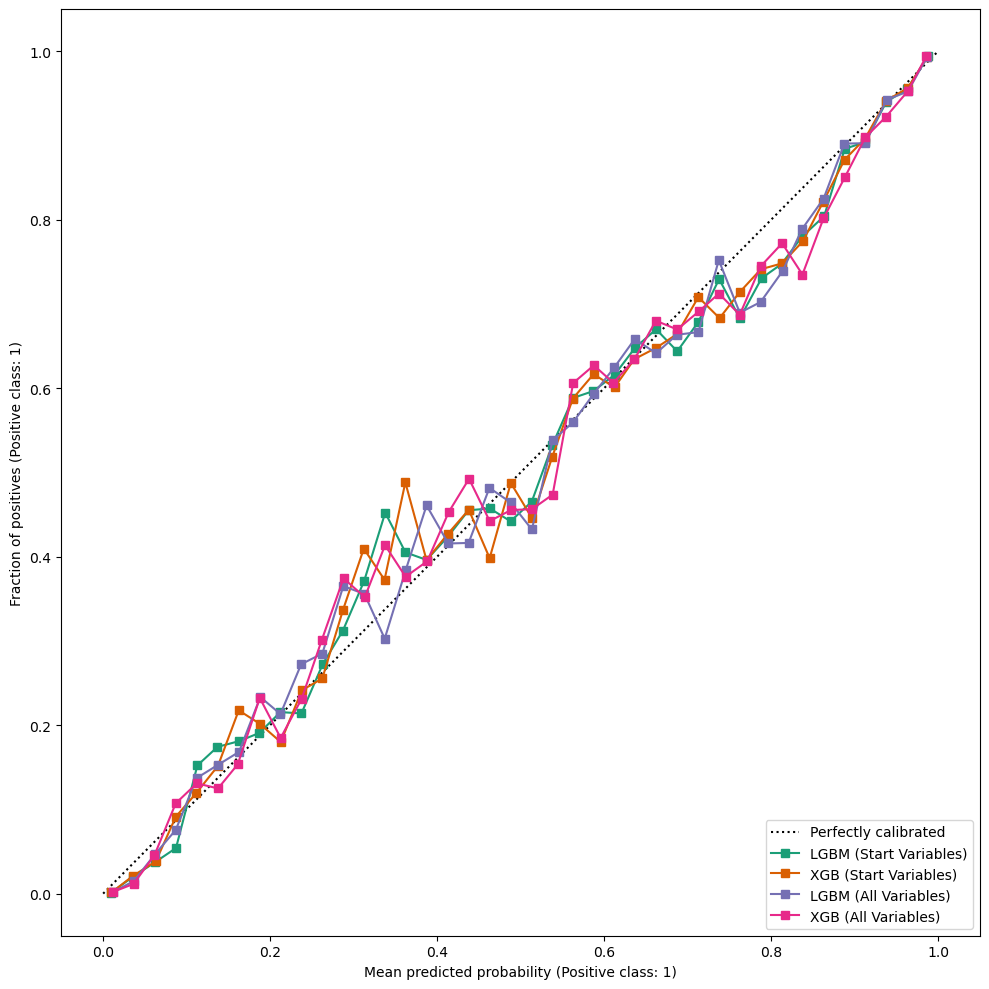

In [19]:
model_list = [
    ("LGBM (Start Variables)", test_begin['winningSideCT'], results_beg["LGBM"]),
    ("XGB (Start Variables)", test_begin['winningSideCT'], results_beg["XGB"]),
    ("LGBM (All Variables)", test_all_variables['winningSideCT'], results_all["LGBM"]),
    ("XGB (All Variables)", test_all_variables['winningSideCT'], results_all["XGB"])
]

colors = plt.cm.get_cmap("Dark2")
fig, axes = plt.subplots(figsize=(10, 10))

for i, (name, y_true, y_pred) in enumerate(model_list):
    display = CalibrationDisplay.from_predictions(
        y_true,
        y_pred,
        n_bins=40,
        name=name,
        ax=axes,
        color=colors(i),
    )
plt.tight_layout()
plt.savefig("graphs/calibration_curve.png")
plt.show()

# Komitet dwóch najlepszych modeli

In [20]:
model_xgb = load_pickle(r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/9f6bb1a1e0d74e6ca465b67d6ac76827/artifacts/model/model.pkl")
model_lgbm = load_pickle(r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/14cd7a9589ce483db318cd4c3aaa6c5a/artifacts/model/model.pkl")
meta_est = load_pickle(r"E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1/5b9bcfd530a1451eb768e862b8ec8dc4/artifacts/model/model.pkl")
test_ensemble = test_frame_begin_variables.copy()
lgbm_pred = model_lgbm.predict_proba(test_frame_begin_variables)[:, 1]
xgb_pred = model_xgb.predict_proba(test_frame_begin_variables)[:, 1]
test_ensemble["lgbm_pred"] = lgbm_pred
test_ensemble["xgb_pred"] = xgb_pred

In [21]:
y_true = test_begin['winningSideCT']
y_pred = meta_est.predict_proba(test_ensemble)[:, 1]
pd.DataFrame({
        "LogLoss (all)": log_loss(y_true, y_pred),
        "LogLoss (future)": log_loss(y_true[future], y_pred[future]),
        "LogLoss (past)": log_loss(y_true[past], y_pred[past]),
        "AUC-ROC (all)": roc_auc_score(y_true, y_pred),
        "AUC-ROC (future)": roc_auc_score(y_true[future], y_pred[future]),
        "AUC-ROC (past)": roc_auc_score(y_true[past], y_pred[past])
}, index=["Ensemble"])

,LogLoss (all),LogLoss (future),LogLoss (past),AUC-ROC (all),AUC-ROC (future),AUC-ROC (past)
Ensemble,0.467957,0.466149,0.469644,0.852372,0.855556,0.848894


# Najlepszy model

## Istotność zmiennych

In [22]:
model_lgbm = load_pickle(begin_variables['LGBM']['path'])
explainer = shap.TreeExplainer(model_lgbm)
shap_values = explainer(test_frame_begin_variables)

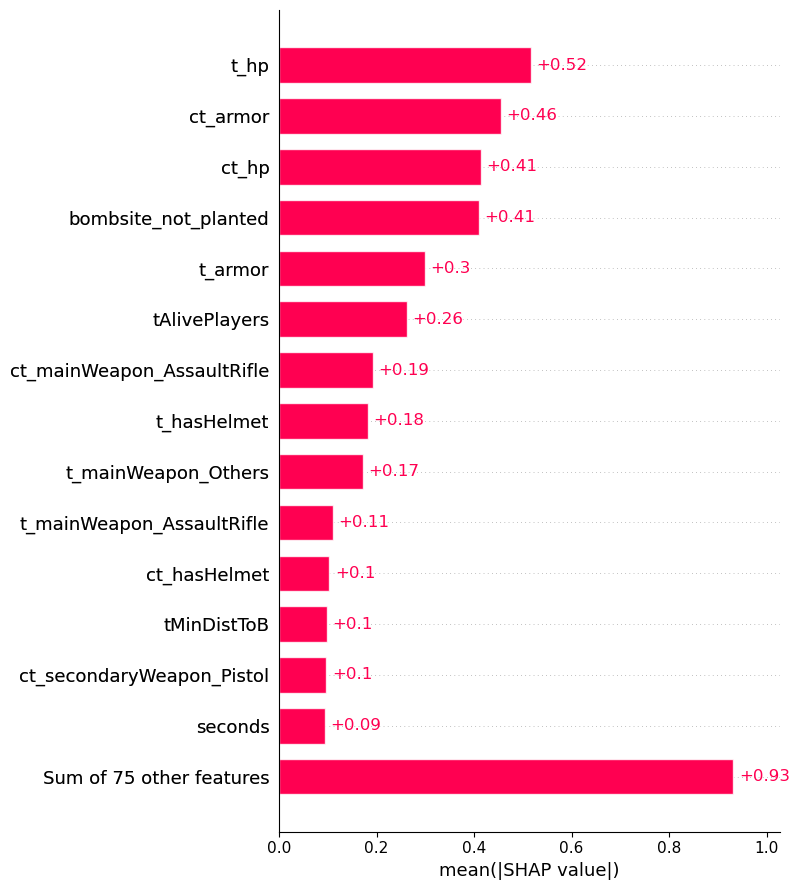

In [23]:
shap.plots.bar(shap_values[:, :, 1], show=False, max_display=15)
plt.tight_layout()
plt.savefig("graphs/variable_importance.png")
plt.show()

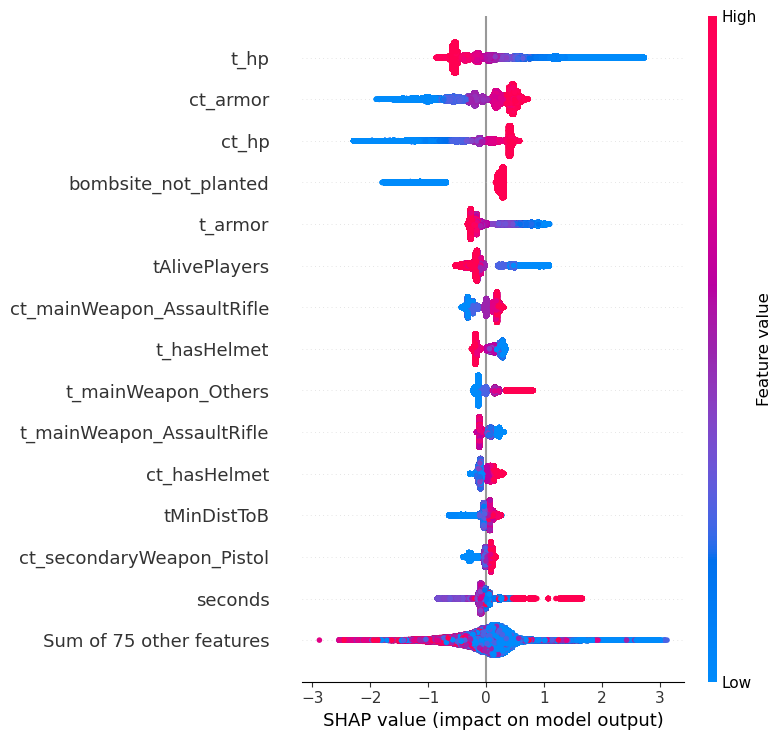

In [24]:
shap.plots.beeswarm(shap_values[:, :, 1], show=False, max_display=15)
plt.tight_layout()
plt.savefig("graphs/variable_importance_values.png")
plt.show()

In [25]:
temp = test_begin[["matchID", "roundNum", "seconds"]].groupby(["matchID", "roundNum"])\
        .agg(id_max=('seconds', 'idxmax'), max_seconds=('seconds', 'max')).reset_index()
test_begin = test_begin.merge(temp, on=["matchID", "roundNum"])
test_begin["new_seconds"] = np.where(test_begin.index > test_begin.id_max, test_begin.seconds + test_begin.max_seconds, test_begin.seconds)
test_begin["new_seconds"]

0           0.148438
1           0.398438
2           0.648438
3           0.898438
4           1.148438
             ...    
620387    115.789062
620388    116.039062
620389    116.289062
620390    116.539062
620391    116.789062
Name: new_seconds, Length: 620392, dtype: float64

In [26]:
def logloss(true_label, predicted, eps=1e-15):
    p = np.clip(predicted, eps, 1 - eps)
    return -(true_label * np.log(p) + (1 - true_label) * np.log(1 - p))

test_begin["log_loss"] = [logloss(true_label=y_true, predicted=y_pred) for y_true, y_pred in zip(test_begin['winningSideCT'], results_beg["LGBM"])]
test_begin["log_loss"]

0         0.675353
1         0.675353
2         0.675353
3         0.675353
4         0.675353
            ...   
620387    0.036403
620388    0.035603
620389    0.035603
620390    0.035603
620391    0.034665
Name: log_loss, Length: 620392, dtype: float64

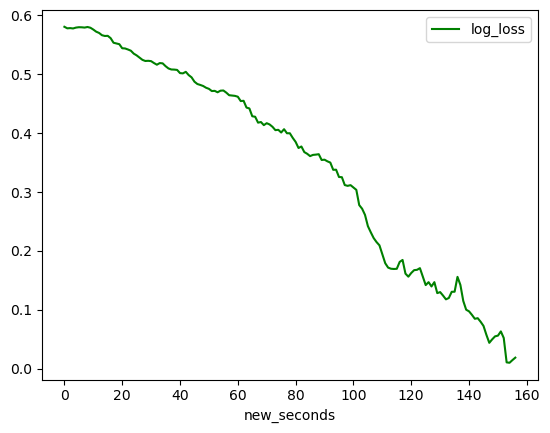

In [27]:
graph_df = test_begin[["new_seconds", "log_loss"]].copy()
graph_df["new_seconds"] = test_begin.new_seconds.round()
graph_df.groupby(by='new_seconds').mean().plot.line(y='log_loss',color='g')
plt.savefig("graphs/log_loss.png")
plt.show()

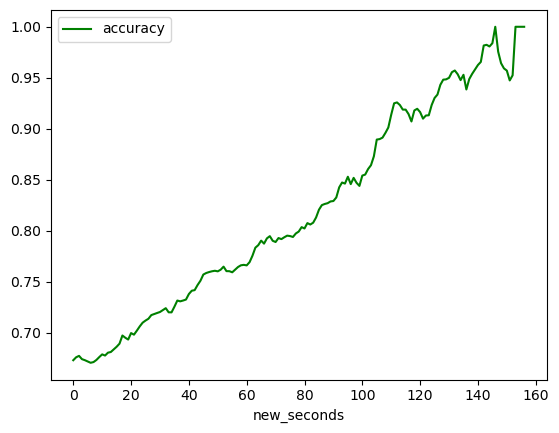

In [28]:
y_pred = (results_beg["LGBM"] >= 0.5)
test_begin["accuracy"] = (test_begin['winningSideCT'] == y_pred)
graph_df = test_begin[["new_seconds", "accuracy"]].copy()
graph_df["new_seconds"] = test_begin.new_seconds.round()
graph_df.groupby(by='new_seconds').mean().plot.line(y='accuracy',color='g')
plt.savefig("graphs/accuracy.png")
plt.show()